In [291]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F
import os, os.path  
import pickle
from glob import glob
import os

import torch.nn as nn
import seaborn as sns
from tqdm import trange
sns.set()

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [292]:
CHECKPOINT_NAME = 'check1'
def save(model, optimiser, grad_step=0):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, CHECKPOINT_NAME)

#To load the model:
#model = TheModelClass(args, **kwargs)
#optimizer = TheOptimizerClass(args, **kwargs)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']
    
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

ROOT_PATH = 'C:\\Users\\sky\\DESKTOP\\argo2\\'

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    #f_in = ROOT_PATH + split + "/" + city + "_inputs"
    f_in = ROOT_PATH + split + "\\" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        #f_out = ROOT_PATH + split + "/" + city + "_outputs"
        f_out = ROOT_PATH + split + "\\" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

def learn_apply_norm(x):
    norm_para = []
    new_x = []
    for each in x:
        start = each[0]
        temp = each-start
        const = np.max(list(np.abs(temp[:50]).flatten()))*2
        new_x.append(temp/const)
        norm_para.append(start)
    return new_x, [norm_para,const]

def apply_norm(x, norm_para):
    new_x = []
    for i in range(len(x)):
        new_x.append((x[i]-norm_para[i][0])/norm_para[i][1])
    return new_x

def apply_norm_reverse(x, norm_para):
    new_x = []
    for i in range(len(x)):
        new_x.append((x[i]*norm_para[i][1])+norm_para[i][0])
    return new_x

In [304]:
class MyRnn(nn.Module):
    def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
        super(MyRnn, self).__init__()
        self.rnn = nn.LSTM(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
        self.fc = nn.Linear(hidden_d, out_d)

    def forward(self, x, h0):
        r, h = self.rnn(x, h0)
        y = self.fc(r)  # no activation on the output
        return y, h

In [305]:
split = 'train'
#cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
cities = ["palo-alto"] # testing only

total =[]
for city in cities:
    data = get_city_trajectories(city = city, split = split)
    total.extend(torch.cat((torch.tensor(data[0], dtype=torch.float),torch.tensor(data[1], dtype=torch.float)),dim=1))

In [306]:
offset = []
new_total = []
for each in total:
    mean = each[:50].mean(dim=0)
    offset.append(mean)
    new_total.append(((each-mean)/100).reshape(110,1,2).to(torch.device('cuda')))

In [ ]:
in_d = 2
out_d = 2
hidden_d = 50
num_hidden = 10
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden).to(torch.device('cuda'))
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(params=rnn.parameters(), lr=0.0000001)
n_epochs = 20
for e in trange(n_epochs):
    track = 0
    for s in new_total:
        for curr in range(60):
            h_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float).to(torch.device('cuda'))
            c_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float).to(torch.device('cuda'))
            pred, _ = rnn(s[curr:curr+50,...], (h_0, c_0))
            #pred, _ = rnn(s[:50,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float).to(torch.device('cuda')))
            err = criterion(pred, s[curr+1:curr+51,...])
            opt.zero_grad()
            err.backward()
            opt.step()
            loss.append(err.item())
        track += 1
        if (track%100==0): print(track/len(new_total)*100)
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

0.8338197281747686
1.6676394563495371
2.5014591845243057
3.3352789126990743
4.169098640873843
5.002918369048611
5.83673809722338
6.670557825398149
7.504377553572918
8.338197281747686
9.172017009922454
10.005836738097223
10.839656466271991
11.67347619444676
12.507295922621529
13.341115650796297
14.174935378971066
15.008755107145836
15.842574835320603
16.67639456349537
17.510214291670138
18.34403401984491
19.177853748019675
20.011673476194446
20.845493204369212
21.679312932543983
22.513132660718753
23.34695238889352
24.18077211706829
25.014591845243057
25.848411573417827
26.682231301592594
27.516051029767365
28.34987075794213
29.1836904861169
30.017510214291672
30.85132994246644
31.685149670641206
32.518969398815976
33.35278912699074
34.18660885516551
35.020428583340276
35.85424831151505
36.68806803968982
37.521887767864584
38.35570749603935
39.189527224214125
40.02334695238889
40.85716668056366
41.690986408738425
42.5248061369132
43.358625865087966
44.19244559326273
45.026265321437506
4

  5%|███▊                                                                        | 1/20 [2:20:25<44:28:12, 8425.93s/it]

0.8338197281747686
1.6676394563495371
2.5014591845243057
3.3352789126990743
4.169098640873843
5.002918369048611
5.83673809722338
6.670557825398149
7.504377553572918
8.338197281747686
9.172017009922454
10.005836738097223
10.839656466271991
11.67347619444676
12.507295922621529
13.341115650796297
14.174935378971066
15.008755107145836
15.842574835320603
16.67639456349537
17.510214291670138
18.34403401984491
19.177853748019675
20.011673476194446
20.845493204369212
21.679312932543983
22.513132660718753
23.34695238889352
24.18077211706829
25.014591845243057
25.848411573417827
26.682231301592594
27.516051029767365
28.34987075794213
29.1836904861169
30.017510214291672
30.85132994246644
31.685149670641206
32.518969398815976
33.35278912699074
34.18660885516551
35.020428583340276
35.85424831151505
36.68806803968982
37.521887767864584
38.35570749603935
39.189527224214125
40.02334695238889
40.85716668056366
41.690986408738425
42.5248061369132
43.358625865087966
44.19244559326273
45.026265321437506
4

 10%|███████▌                                                                    | 2/20 [4:40:51<42:07:42, 8425.70s/it]

0.8338197281747686
1.6676394563495371
2.5014591845243057
3.3352789126990743
4.169098640873843
5.002918369048611
5.83673809722338
6.670557825398149
7.504377553572918
8.338197281747686
9.172017009922454
10.005836738097223
10.839656466271991
11.67347619444676
12.507295922621529
13.341115650796297
14.174935378971066
15.008755107145836
15.842574835320603
16.67639456349537
17.510214291670138
18.34403401984491
19.177853748019675
20.011673476194446
20.845493204369212
21.679312932543983
22.513132660718753
23.34695238889352
24.18077211706829
25.014591845243057
25.848411573417827
26.682231301592594
27.516051029767365
28.34987075794213
29.1836904861169
30.017510214291672
30.85132994246644
31.685149670641206
32.518969398815976
33.35278912699074
34.18660885516551
35.020428583340276
35.85424831151505
36.68806803968982
37.521887767864584
38.35570749603935
39.189527224214125
40.02334695238889
40.85716668056366
41.690986408738425
42.5248061369132
43.358625865087966
44.19244559326273
45.026265321437506
4

 15%|███████████▍                                                                | 3/20 [7:01:18<39:47:25, 8426.23s/it]

0.8338197281747686
1.6676394563495371
2.5014591845243057
3.3352789126990743
4.169098640873843
5.002918369048611
5.83673809722338
6.670557825398149
7.504377553572918
8.338197281747686
9.172017009922454
10.005836738097223
10.839656466271991
11.67347619444676
12.507295922621529
13.341115650796297
14.174935378971066
15.008755107145836
15.842574835320603
16.67639456349537
17.510214291670138
18.34403401984491
19.177853748019675
20.011673476194446
20.845493204369212
21.679312932543983
22.513132660718753
23.34695238889352
24.18077211706829
25.014591845243057
25.848411573417827
26.682231301592594
27.516051029767365
28.34987075794213
29.1836904861169
30.017510214291672
30.85132994246644
31.685149670641206
32.518969398815976
33.35278912699074
34.18660885516551
35.020428583340276
35.85424831151505
36.68806803968982
37.521887767864584
38.35570749603935
39.189527224214125
40.02334695238889
40.85716668056366
41.690986408738425
42.5248061369132
43.358625865087966
44.19244559326273
45.026265321437506
4

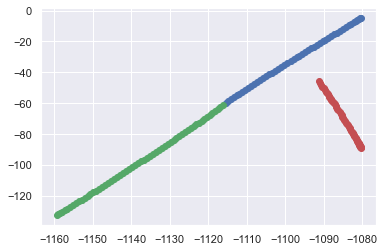

In [369]:
idx=np.random.randint(10000)

rnn.eval()
with torch.no_grad():
    k = 50
    s = new_total[idx]
    pred_s = []
    h_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float).to(torch.device('cuda'))
    c_0 = torch.randn(num_hidden, 1, hidden_d, dtype=torch.float).to(torch.device('cuda'))
    pred, h = rnn(s[:50,...], (h_0, c_0))
    prev = pred[-1:, ...]
    pred_s.append(prev[-1:])
    for j in  range(51,110):
        pred, h = rnn(prev, h)
        prev = pred
        pred_s.append(prev)

        
ori = (np.array(s.cpu()[:50]).reshape(50,2))*100+offset[idx].numpy()
truth = (np.array(s.cpu()[50:]).reshape(60,2))*100+offset[idx].numpy()
pred = []
for each in pred_s:
    pred.append(each[0][0].cpu().numpy())
pred = (np.array(pred).reshape(60,2))*100+offset[idx].numpy()

plt.scatter(ori[:,0],ori[:,1],color='b')
plt.scatter(truth[:,0],truth[:,1],color='g')
plt.scatter(pred[:,0],pred[:,1],color='r')

In [935]:
test_loss = []
for test in range(0,8,1):

    loss = []
    #for idx in range(len(x)):
    for _ in range(1000):
        idx = np.random.randint(len(x))
        x_temp = x[idx]
        y_temp = y[idx]
        offset = x_temp[0]
        x_temp = x_temp-offset
        scale = np.max(np.abs(x_temp))*2
        x_temp = x_temp / scale
        y_temp = (y_temp-offset)/scale
        df_train=pd.DataFrame(x_temp)
        df_test=pd.DataFrame(y_temp)

        #df_train=pd.DataFrame(x[idx])
        #df_test=pd.DataFrame(y[idx])

        nobs=60
        model = VAR(df_train)
        model_fitted = model.fit(48)
        lag_order = model_fitted.k_ar
        forecast_input = df_train.values[-lag_order:]
        fc = model_fitted.forecast(y=forecast_input, steps=nobs)

        fc = fc*scale+offset

        for i in range(len(fc)):
            if (np.abs(fc[i][0]) > 20000 or (np.abs(fc[i][0]-x[idx][49][0])>150)):
                fc[i][0] = x[idx][49][0]
            if (np.abs(fc[i][1]) > 20000 or (np.abs(fc[i][1]-x[idx][49][1])>150)):
                fc[i][1] = x[idx][49][1]

            if (i!=0 and (np.abs(np.abs(fc[i][0])-np.abs(fc[i-1][0])) > 3)):
                fc[i][0] = x[idx][49][0]
            if (i!=0 and (np.abs(np.abs(fc[i][1])-np.abs(fc[i-1][1])) > 3)):
                fc[i][1] = x[idx][49][1]


        curr_loss = (np.mean((fc - y[idx])**2))
        loss.append(curr_loss)
        if (curr_loss>10000):        
            plt.scatter(x[idx][:,0],x[idx][:,1],color='b',alpha=0.3)
            plt.scatter(y[idx][:,0],y[idx][:,1],color='g',alpha=0.3)
            plt.scatter(fc[:,0],fc[:,1],color='r',alpha=0.3)
            print(curr_loss)
            break
    print(test, np.mean(loss))
    test_loss.append(np.mean(loss))

0 365.47746120740106
1 250.31886417200906
2 61.833125758558246
3 49.45942745660844
4 55.352734171113774
5 55.746398335482304
6 68.14453512250249
7 71.84537188358159


In [951]:
loss = []
#for idx in range(len(x)):
for _ in range(1000):
    idx = np.random.randint(len(x))
    x_temp = x[idx]
    y_temp = y[idx]
    offset = x_temp[0]
    x_temp = x_temp-offset
    scale = np.max(np.abs(x_temp))*2
    x_temp = x_temp / scale
    y_temp = (y_temp-offset)/scale
    df_train=pd.DataFrame(x_temp)
    df_test=pd.DataFrame(y_temp)

    #df_train=pd.DataFrame(x[idx])
    #df_test=pd.DataFrame(y[idx])

    nobs=60
    model = VAR(df_train)
    model_fitted = model.fit(48)
    lag_order = model_fitted.k_ar
    forecast_input = df_train.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)

    fc = fc*scale+offset

    for i in range(len(fc)):
        if (np.abs(fc[i][0]) > 20000 or (np.abs(fc[i][0]-x[idx][49][0])>150)):
            fc[i][0] = x[idx][49][0]
        if (np.abs(fc[i][1]) > 20000 or (np.abs(fc[i][1]-x[idx][49][1])>150)):
            fc[i][1] = x[idx][49][1]

        if (i!=0 and (np.abs(np.abs(fc[i][0])-np.abs(fc[i-1][0])) > 3)):
            fc[i][0] = fc[i-1][0]
        if (i!=0 and (np.abs(np.abs(fc[i][1])-np.abs(fc[i-1][1])) > 3)):
            fc[i][1] = fc[i-1][1]


    curr_loss = (np.mean((fc - y[idx])**2))
    loss.append(curr_loss)
    if (curr_loss>10000):        
        plt.scatter(x[idx][:,0],x[idx][:,1],color='b',alpha=0.3)
        plt.scatter(y[idx][:,0],y[idx][:,1],color='g',alpha=0.3)
        plt.scatter(fc[:,0],fc[:,1],color='r',alpha=0.3)
        print(curr_loss)
        break
print(np.mean(loss))

44.033958085023606


2.328757481054107


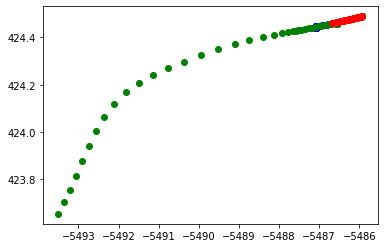

In [747]:
plt.scatter(x[idx][:,0],x[idx][:,1],color='b')
plt.scatter(y[idx][:,0],y[idx][:,1],color='g')
plt.scatter(fc[:,0],fc[:,1],color='r')

print(np.mean((fc - y[idx])**2)**.5)

In [952]:
split = 'test'
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
#cities = ["palo-alto"] # testing only


x =[]
for city in cities:
    data = get_city_trajectories(city = city, split = split)
    x.extend(data[0])

out = []

length = len(x)

for idx in range(length):
    x_temp = x[idx]
    offset = x_temp[0]
    x_temp = x_temp-offset
    scale = np.max(np.abs(x_temp))*2
    x_temp = x_temp / scale
    df_train=pd.DataFrame(x_temp)
    nobs=60
    model = VAR(df_train)
    model_fitted = model.fit(48)
    lag_order = model_fitted.k_ar
    forecast_input = df_train.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    fc = fc*scale+offset
    
    for i in range(len(fc)):
        if (np.abs(fc[i][0]) > 20000 or (np.abs(fc[i][0]-x[idx][49][0])>150)):
            fc[i][0] = x[idx][49][0]
        if (np.abs(fc[i][1]) > 20000 or (np.abs(fc[i][1]-x[idx][49][1])>150)):
            fc[i][1] = x[idx][49][1]

        if (i!=0 and (np.abs(np.abs(fc[i][0])-np.abs(fc[i-1][0])) > 3)):
            fc[i][0] = fc[i-1][0]
        if (i!=0 and (np.abs(np.abs(fc[i][1])-np.abs(fc[i-1][1])) > 3)):
            fc[i][1] = fc[i-1][1]
            
    
    temp = []
    for each in fc:
        temp.append(each[0])
        temp.append(each[1])
    out.append(temp)
    
    if(idx%((int)(length/20))==0):
        print(((int)(idx/length))*100,"%")

0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %
0 %


In [953]:
out_df = pd.DataFrame(out)
sample = pd.read_csv('C:\\Users\\sky\\DESKTOP\\argo2\\sample_submission.csv').set_index('ID')
out_df.columns = sample.columns
out_df.index = sample.index
out_df.to_csv('s2.csv')

In [872]:
out_df.describe()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
count,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,...,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000,29843.000000
mean,2831.163152,1075.581425,2831.151274,1075.578779,2831.139346,1075.576231,2831.127384,1075.573794,2831.115412,1075.571503,...,2830.511275,1075.524456,2830.506154,1075.512261,2830.475164,1075.492343,2830.430431,1075.483211,2830.387812,1075.439664
std,3343.238477,1728.479878,3343.230917,1728.473439,3343.223385,1728.467068,3343.215890,1728.460776,3343.208465,1728.454585,...,3342.741744,1728.539449,3342.795356,1728.512172,3342.793790,1728.534801,3342.826931,1728.595268,3342.791908,1728.633235
min,-9197.998640,-4497.570260,-9197.966007,-4497.565554,-9197.940147,-4497.560495,-9197.921874,-4497.555188,-9197.911863,-4497.549719,...,-9197.846326,-4500.468359,-9197.842947,-4501.672636,-9197.837781,-4502.924720,-9197.830887,-4504.228254,-9197.822380,-4505.587057
25%,357.525373,-107.601739,356.921181,-107.841612,356.583054,-107.936729,356.393837,-108.485329,356.331405,-108.185019,...,358.736281,-106.845475,358.406179,-106.888568,358.714584,-107.434527,358.502061,-107.211603,358.395786,-106.854692
50%,2361.880013,1125.565100,2362.441738,1125.574773,2362.787439,1125.584355,2362.780967,1125.593877,2362.774905,1125.466725,...,2364.409992,1126.530022,2363.231194,1126.275323,2363.428729,1126.110576,2362.669943,1125.818029,2362.669528,1126.130289
75%,5416.515307,2324.055353,5416.509562,2324.166224,5416.504035,2324.204054,5416.605082,2324.497608,5416.493287,2324.555703,...,5417.975007,2323.314351,5417.992360,2323.445545,5418.022709,2323.569942,5417.943636,2323.584326,5417.856221,2323.643258
max,13217.822315,6529.106436,13217.996515,6527.937960,13218.177535,6526.785530,13218.365603,6525.647855,13218.560972,6524.523823,...,13250.604928,6499.308280,13252.083407,6499.284161,13253.620812,6499.264072,13255.219493,6499.247840,13256.881894,6499.235297


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [ ]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [4]:
#combining x and y for training
x,y = [],[]
x.extend(posX_x)
x.extend(posY_x)
y.extend(posX_y)
y.extend(posY_y)

In [5]:
#only predict 1
forecast_length = 1
backcast_length = 50

total = []
for i in range(len(x)):
    total.append(x[i])
    total.append(y[i])

x, y = [],[]
for each in total:
    for epoch in range(backcast_length, len(each) - forecast_length):
        x.append(each[epoch - backcast_length:epoch])
        y.append(each[epoch:epoch + forecast_length])
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32)

In [5]:
#train-test spliting and normalization

x, norm_para = learn_apply_norm(x)
y = apply_norm(y,norm_para)

c = int(len(x) * 0.8)
x_train, y_train = x[:c], y[:c]
x_test, y_test = x[c:], y[c:]

#norm_constant = np.max(np.abs(x_train))
#x_train, y_train = x_train / norm_constant, y_train / norm_constant
#x_test, y_test = x_test / norm_constant, y_test / norm_constant

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107549104
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107550064
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107549296
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107641056
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107641680
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=50, forecast_length=60, share_thetas=False) at @1777107641632


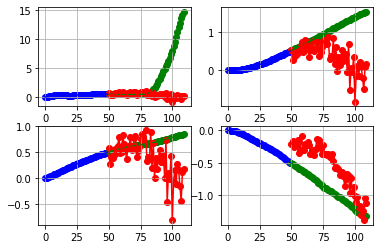

epoch = 0000, grad_step = 000408, tr_loss (epoch) = 4133422587.413414, te_loss (epoch) = 4219768554.687500


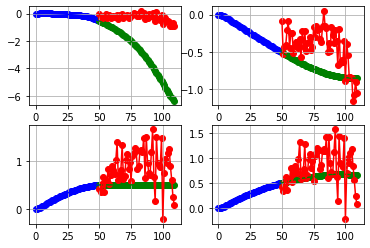

epoch = 0001, grad_step = 000816, tr_loss (epoch) = 4133185089.560116, te_loss (epoch) = 4220034667.968750


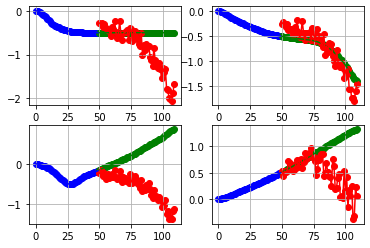

epoch = 0002, grad_step = 001224, tr_loss (epoch) = 4132745681.538301, te_loss (epoch) = 4220042480.468750


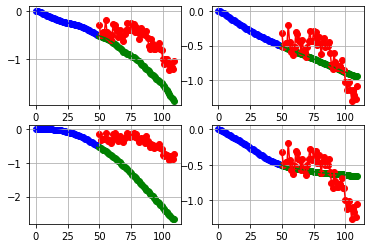

epoch = 0003, grad_step = 001632, tr_loss (epoch) = 4132716564.889048, te_loss (epoch) = 4220004882.812500


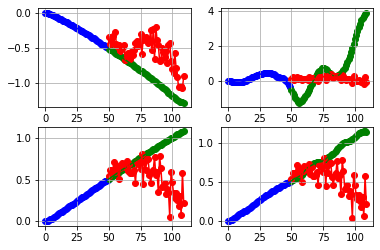

epoch = 0004, grad_step = 002040, tr_loss (epoch) = 4132136358.148911, te_loss (epoch) = 4220104003.906250


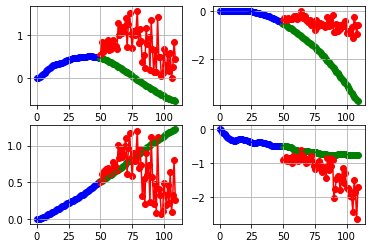

epoch = 0005, grad_step = 002448, tr_loss (epoch) = 4131854490.579343, te_loss (epoch) = 4219980468.750000


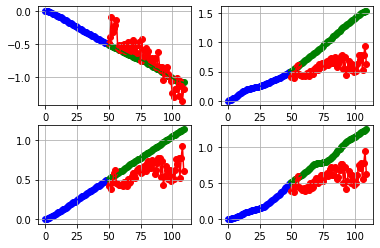

epoch = 0006, grad_step = 002856, tr_loss (epoch) = 4132150053.585277, te_loss (epoch) = 4220151367.187500


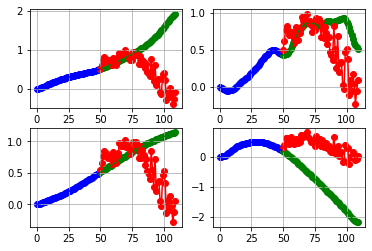

epoch = 0007, grad_step = 003264, tr_loss (epoch) = 4129631255.804324, te_loss (epoch) = 4220812988.281250


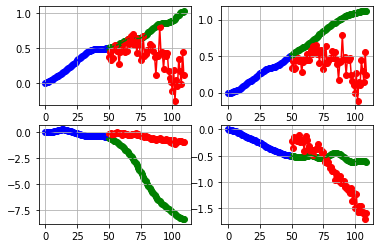

epoch = 0008, grad_step = 003672, tr_loss (epoch) = 4125762325.174668, te_loss (epoch) = 4222543945.312500


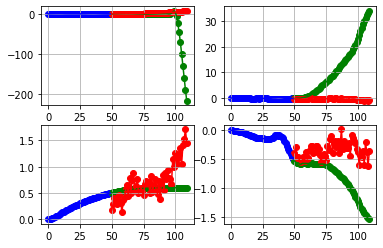

epoch = 0009, grad_step = 004080, tr_loss (epoch) = 4121137833.239985, te_loss (epoch) = 4221328613.281250


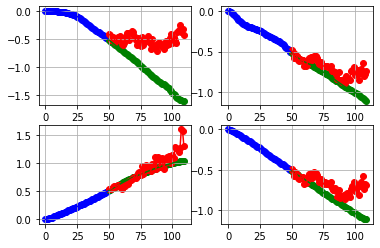

epoch = 0010, grad_step = 004488, tr_loss (epoch) = 4119059934.279498, te_loss (epoch) = 4225142089.843750


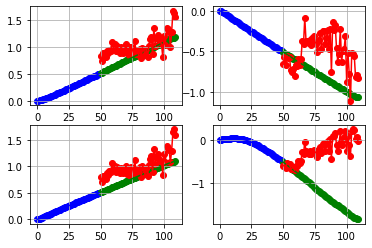

epoch = 0011, grad_step = 004896, tr_loss (epoch) = 4112789063.023586, te_loss (epoch) = 4232468750.000000


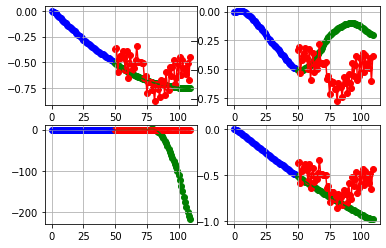

epoch = 0012, grad_step = 005304, tr_loss (epoch) = 4112184877.021640, te_loss (epoch) = 4225909667.968750


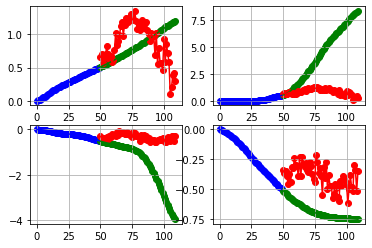

epoch = 0013, grad_step = 005712, tr_loss (epoch) = 4107779758.677763, te_loss (epoch) = 4228663574.218750


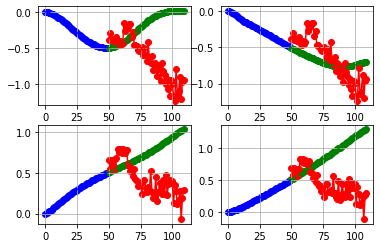

epoch = 0014, grad_step = 006120, tr_loss (epoch) = 4097982078.851438, te_loss (epoch) = 4236390136.718750


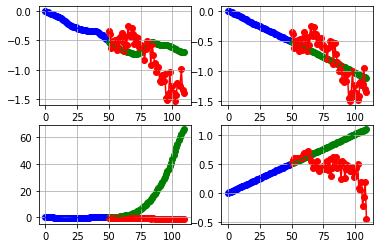

epoch = 0015, grad_step = 006528, tr_loss (epoch) = 4085200715.943879, te_loss (epoch) = 4243006835.937500


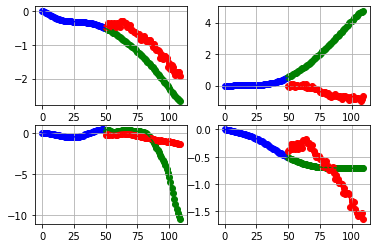

epoch = 0016, grad_step = 006936, tr_loss (epoch) = 4069102875.017653, te_loss (epoch) = 4264626464.843750


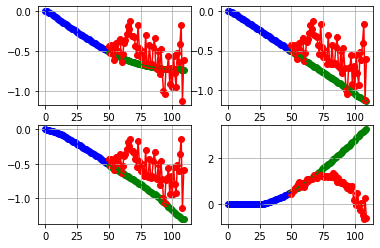

epoch = 0017, grad_step = 007344, tr_loss (epoch) = 4050245733.036714, te_loss (epoch) = 4260016113.281250


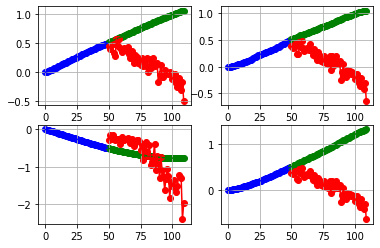

epoch = 0018, grad_step = 007752, tr_loss (epoch) = 4061463934.917076, te_loss (epoch) = 4294402343.750000


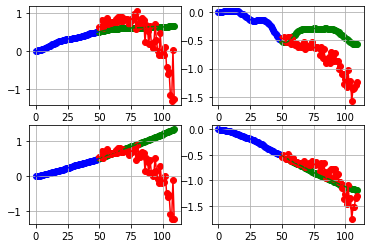

epoch = 0019, grad_step = 008160, tr_loss (epoch) = 4025629675.584681, te_loss (epoch) = 4309435546.875000


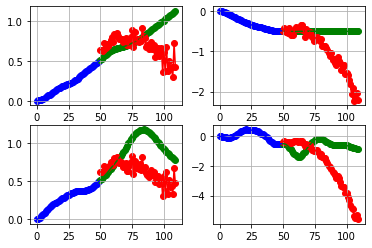

epoch = 0020, grad_step = 008568, tr_loss (epoch) = 4037861275.729011, te_loss (epoch) = 4301749511.718750


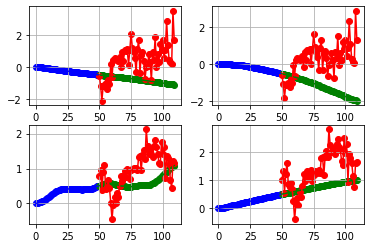

epoch = 0021, grad_step = 008976, tr_loss (epoch) = 4035824253.531063, te_loss (epoch) = 4382455078.125000


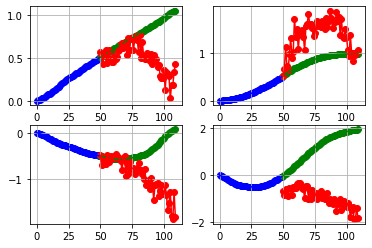

epoch = 0022, grad_step = 009384, tr_loss (epoch) = 3983780451.643701, te_loss (epoch) = 4306813476.562500


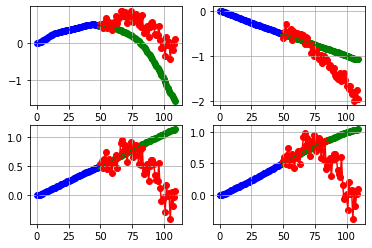

epoch = 0023, grad_step = 009792, tr_loss (epoch) = 3992547421.174891, te_loss (epoch) = 4358148437.500000


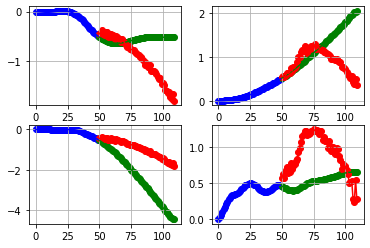

epoch = 0024, grad_step = 010200, tr_loss (epoch) = 3920312292.024201, te_loss (epoch) = 4438704589.843750


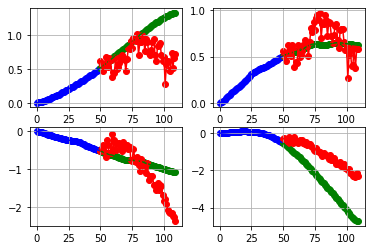

epoch = 0025, grad_step = 010608, tr_loss (epoch) = 3902441397.461236, te_loss (epoch) = 4646774414.062500


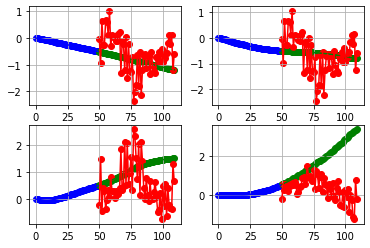

epoch = 0026, grad_step = 011016, tr_loss (epoch) = 3897678912.181480, te_loss (epoch) = 4655932617.187500


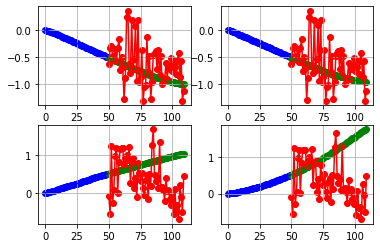

epoch = 0027, grad_step = 011424, tr_loss (epoch) = 3841809953.203388, te_loss (epoch) = 4472183105.468750


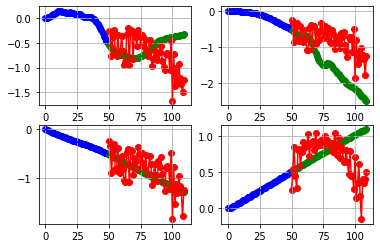

epoch = 0028, grad_step = 011832, tr_loss (epoch) = 3894081262.962491, te_loss (epoch) = 4329140136.718750


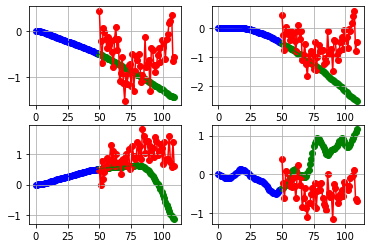

epoch = 0029, grad_step = 012240, tr_loss (epoch) = 3796585278.380151, te_loss (epoch) = 4564683105.468750


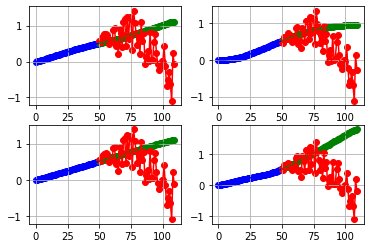

epoch = 0030, grad_step = 012648, tr_loss (epoch) = 3762602583.679498, te_loss (epoch) = 4578139648.437500


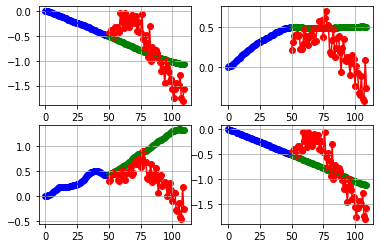

epoch = 0031, grad_step = 013056, tr_loss (epoch) = 3807002748.900769, te_loss (epoch) = 4451399414.062500


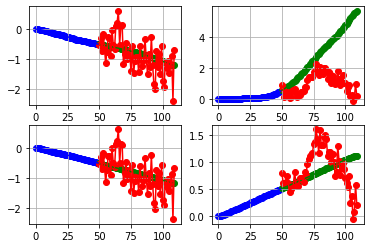

epoch = 0032, grad_step = 013464, tr_loss (epoch) = 3855446376.052557, te_loss (epoch) = 4505584472.656250


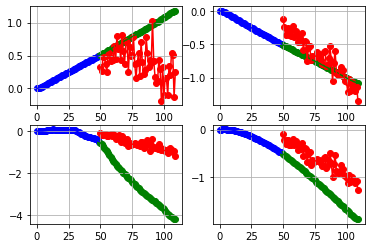

epoch = 0033, grad_step = 013872, tr_loss (epoch) = 3733174567.951875, te_loss (epoch) = 4515535156.250000


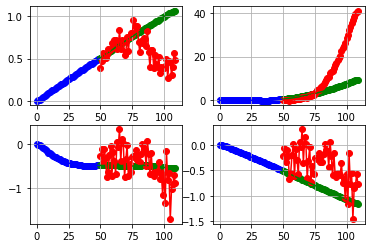

epoch = 0034, grad_step = 014280, tr_loss (epoch) = 3743019424.438477, te_loss (epoch) = 4500504394.531250


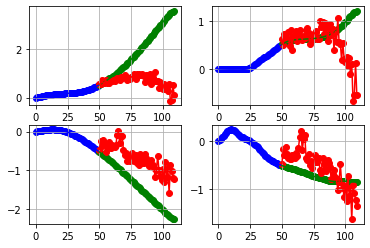

epoch = 0035, grad_step = 014688, tr_loss (epoch) = 3713145511.627197, te_loss (epoch) = 4477718750.000000


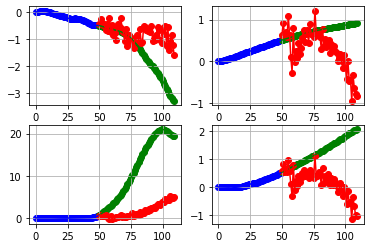

epoch = 0036, grad_step = 015096, tr_loss (epoch) = 3715835418.289783, te_loss (epoch) = 4517384277.343750


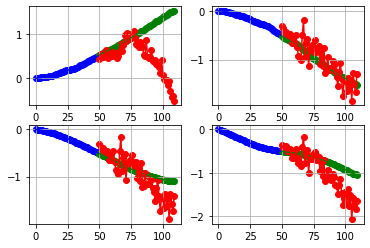

epoch = 0037, grad_step = 015504, tr_loss (epoch) = 3668424739.089667, te_loss (epoch) = 4380876464.843750


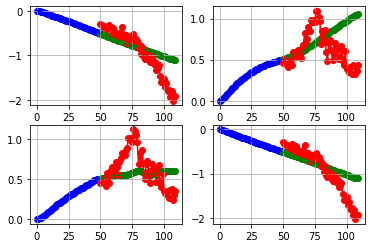

epoch = 0038, grad_step = 015912, tr_loss (epoch) = 3655067826.439353, te_loss (epoch) = 4541673828.125000


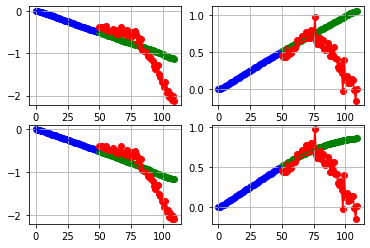

epoch = 0039, grad_step = 016320, tr_loss (epoch) = 3663457007.464241, te_loss (epoch) = 4505764160.156250


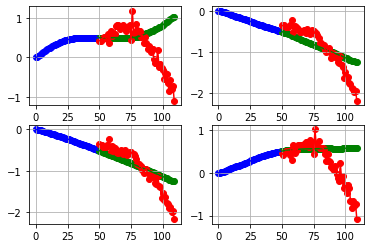

epoch = 0040, grad_step = 016728, tr_loss (epoch) = 3605822776.981429, te_loss (epoch) = 4487387695.312500


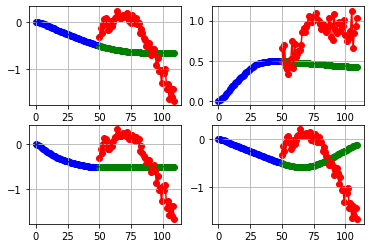

epoch = 0041, grad_step = 017136, tr_loss (epoch) = 3622485176.385618, te_loss (epoch) = 4413671386.718750


KeyboardInterrupt: 

In [13]:
batch_size = 800
epoch = 20000

net = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=forecast_length,
    backcast_length=backcast_length,
    hidden_layer_units=128,
    device=torch.device('cuda'),
)
optimiser = optim.Adam(lr=0.000003, params=net.parameters())
#optimiser = optim.Adam(lr=0.003, params=net.parameters())

grad_step = 0
for epoch in range(epoch):
    net.train()
    train_loss = []
    for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
        grad_step += 1
        optimiser.zero_grad()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
        train_loss.append(loss.item())
        loss.backward()
        optimiser.step()
    train_loss = np.mean(train_loss)

    # test.
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float).to(net.device))
    test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
    p = forecast.cpu().detach().numpy()
    if epoch % 1 == 0:
        subplots = [221, 222, 223, 224]
        plt.figure(1)
        for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
            ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
            #ff, xx, yy = p[i], x_test[i], y_test[i]
            plt.subplot(subplots[plot_id])
            plt.grid()
            plot_scatter(range(0, backcast_length), xx, color='b')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
            plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
        plt.show()

        #with torch.no_grad():
        #    save(net, optimiser, grad_step)
        print(f'epoch = {str(epoch).zfill(4)}, '
              f'grad_step = {str(grad_step).zfill(6)}, '
              f'tr_loss (epoch) = {1000000 * train_loss:.6f}, '
              f'te_loss (epoch) = {1000000 * test_loss:.6f}')


In [19]:
with torch.no_grad():
    save(net, optimiser, grad_step)

In [46]:
split = 'test'
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
#cities = ["palo-alto"] # testing only


posX_x, posY_x =[],[]
for city in cities:
    data = get_city_trajectories(city = city, split = split)
    posX_x.extend(data[0][:,:,0].tolist())
    posY_x.extend(data[0][:,:,1].tolist())

posX_x = np.array(posX_x).astype(np.float32) / norm_constant
posY_x = np.array(posY_x).astype(np.float32) / norm_constant

net.eval()
_, forecast = net(torch.tensor(posX_x, dtype=torch.float).to(net.device))
p_X = forecast.cpu().detach().numpy()

_, forecast = net(torch.tensor(posY_x, dtype=torch.float).to(net.device))
p_Y = forecast.cpu().detach().numpy()

out = []
for idx in range(len(p_X)):
    temp = p_X[idx].tolist()
    temp.extend(p_Y[idx].tolist())
    out.append(temp)

out_df = pd.DataFrame(out) * norm_constant

In [50]:
sample = pd.read_csv('C:\\Users\\sky\\DESKTOP\\argo2\\sample_submission.csv').set_index('ID')
out_df.columns = sample.columns
out_df.index = sample.index
out_df.to_csv('s1.csv')

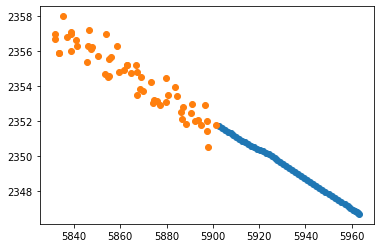

In [170]:
idx = np.random.randint(29843)
plt.scatter((posX_x * norm_constant)[idx], (posY_x * norm_constant)[idx])
plt.scatter(out_df.iloc[idx][0:59], out_df.iloc[idx][60:119])